# Yet another attempt to train a model that doesn't take ages
## Strategy here: first compute and save all spectrograms, then sample from spectrograms for training

### Imports

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import h5py

import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

import keras
import tensorflow_io as tfio
import tensorflow_probability as tfp
import tensorflow_extra as tfe

import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

XC_ROOTDIR = '../../data/' # directory to save data in
XC_DIR = 'test_dataset10' # subdirectory name of dataset

#tf.config.set_visible_devices([], 'GPU')

2024-07-13 00:33:55.387278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Read data

In [2]:
df = pd.read_csv("../../data/dataset10.csv")
#df["fullfilename"] = "../" + df["fullfilename"]

### Configuration

In [3]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 22050
    duration = 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = 32
    n_epochs = 50
    
    # class labels/names
    names = list(np.unique(df.en))
    n_classes = len(names)
    labels = list(range(n_classes))
    label2name = dict(zip(labels, names))
    name2label = {v:k for k,v in label2name.items()}

# set random seed in keras
tf.keras.utils.set_random_seed(cfg.seed)

## Load all audios, compute and save spectrograms

### Functions to compute, save and load spectrogram

In [4]:
def compute_spec(filepath, sr=cfg.sr, duration=cfg.duration, nfft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax):
    audio, sr = librosa.load(filepath, sr = sr)
    # randomly pad clip if shorter
    if len(audio) < duration*sr:
        _ = np.zeros(duration*sr)
        rand_idx = np.random.randint(0, duration*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmin = 0, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

def save_spec_to_hdf5(spec, hdf5_path, name, compression="gzip", chunks=True):
    try:
        with h5py.File(hdf5_path, 'a') as f:  # Open in append mode
            f.create_dataset(name, data=spec, compression=compression, chunks=chunks)
    except Exception as e:
        print(f'Error saving spectrograms to {hdf5_path}: {e}')

In [5]:
def compute_and_save_spec(filepath, return_length = False):
    spec = compute_spec(filepath)
    name = Path(filepath).stem
    hdf5_path = os.path.dirname(filepath) + "/spectrograms.h5"
    save_spec_to_hdf5(spec, hdf5_path = hdf5_path, name = name)
    if return_length:
        return spec.shape[-1]

def load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None):
    with h5py.File(hdf5_path, 'r') as f:
        spectrogram_slice = f[name][start_row:end_row, start_col:end_col]
    return spectrogram_slice

In [6]:
spec = compute_spec(df.fullfilename.iloc[0])
spec.shape

(128, 3226)

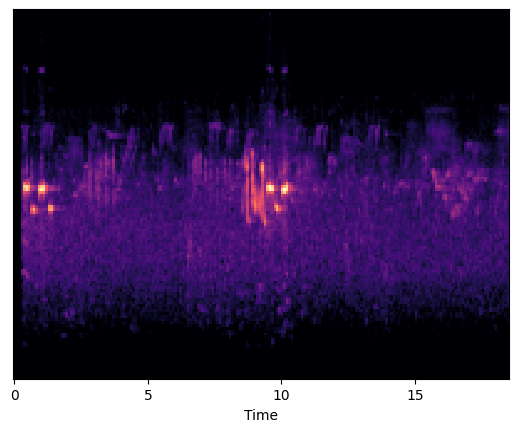

In [7]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

In [8]:
path = df.fullfilename.iloc[0]
compute_and_save_spec(path)

Error saving spectrograms to ../../data/dataset10/Turdus merula_Common Blackbird/spectrograms.h5: Unable to synchronously create dataset (name already exists)


In [9]:
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
spec.shape

(128, 3226)

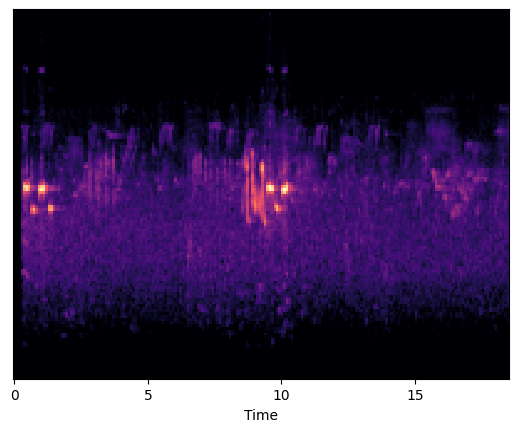

In [10]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

### Compute and save spectrograms for all audios in the dataset

In [11]:
if not "spectrogram" in df.columns:
    df["spectrogram"] = None
if not "length_spectrogram" in df.columns:
    df["length_spectrogram"] = None
for i in tqdm(range(len(df))):
    filepath = df.fullfilename.iloc[i]
    if df.loc[i, "spectrogram"] is None:
        df.loc[i, "length_spectrogram"] = compute_and_save_spec(filepath, return_length = True)
        df.loc[i, "spectrogram"] = Path(filepath).stem


df.to_csv("../../data/dataset10.csv", index = False)

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 29383.54it/s]


(128, 2866)


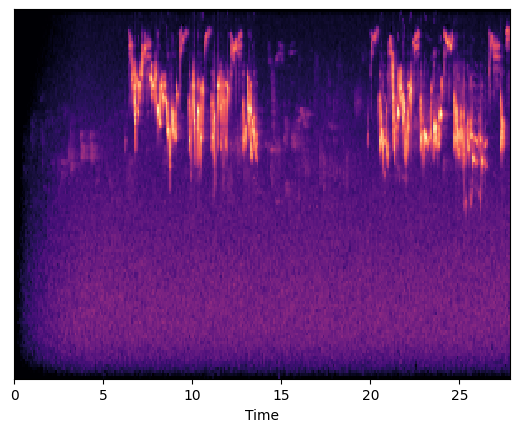

In [12]:
path = df.fullfilename.iloc[42]
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:300], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

## Create data generator for training

### Helper functions

In [13]:
# Generates random integer # from https://www.kaggle.com/code/wengsilu/birdclef24pretraining
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [14]:
cfg.input_dim[1]

162

In [15]:
def load_random_spec_slice(df, ID):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    rdm = random_int(maxval= spec_length - cfg.input_dim[1])
    return load_spectrogram_slice(hdf5_path = hdf5_path, name = name, start_col = rdm, end_col = rdm + cfg.input_dim[1])

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataframe,
                 batch_size=cfg.batch_size, 
                 dim=cfg.input_dim,
                 n_channels =  1,
                 n_classes=cfg.n_classes, 
                 shuffle=True
                ):
        'Initialization'
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.dataframe = dataframe
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_random_spec_slice(self.dataframe, ID).reshape(*self.dim, self.n_channels)
            # Store class
            y[i] = cfg.name2label[df.en.iloc[ID]]
        X = X.reshape(len(X), *self.dim, self.n_channels)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

2024-07-13 00:34:14.333890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:34:14.460619: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:34:14.461067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:34:14.462323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:34:14.462801: I external/local_xla/xla/stream_executor

(128, 162)
(128, 162)


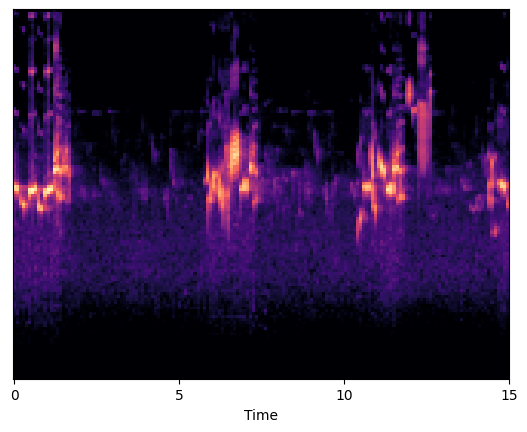

In [16]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax);
print(cfg.input_dim)

## Build model

In [17]:
cfg.input_dim

(128, 162)

In [18]:
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

zscore_layer = tfe.layers.ZScoreMinMax()

def build_model():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Basemodel")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

### Test zscore_layer

In [19]:
specs = []
for i in tqdm(range(50)):
    specs.append(load_random_spec_slice(df, ID = i))
specs = np.array(specs)
print("Before zscore layer: ", specs.min(), specs.max())

print("After zscore layer: ", zscore_layer(specs).numpy().min(), zscore_layer(specs).numpy().max())


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.90it/s]


Before zscore layer:  -63.894543 39.862907
After zscore layer:  0.0 1.0


In [20]:
model = build_model()

Model: "Basemodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 74880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,792,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,813,610 (18.36 MB)

 Trainable params: 4,813,610 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train validation split

In [21]:
from sklearn.model_selection import train_test_split

id_train, id_val, y_train, y_val = train_test_split(range(len(df)), df["en"].to_list(), test_size = 0.3, random_state = cfg.seed)

training_generator = DataGenerator(id_train, y_train, df)
validation_generator = DataGenerator(id_val, y_val, df)

In [22]:
hist = model.fit(training_generator, validation_data=validation_generator, verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


I0000 00:00:1720823663.351243    4725 service.cc:145] XLA service 0x7f79b800b5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720823663.351296    4725 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-07-13 00:34:23.426614: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-13 00:34:23.726786: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1720823670.507042    4725 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 - 13s - 2s/step - accuracy: 0.1094 - loss: 2.4768 - val_accuracy: 0.1094 - val_loss: 2.3095
Epoch 2/50
6/6 - 4s - 610ms/step - accuracy: 0.1042 - loss: 2.3046 - val_accuracy: 0.0625 - val_loss: 2.3118
Epoch 3/50
6/6 - 4s - 594ms/step - accuracy: 0.1458 - loss: 2.2950 - val_accuracy: 0.0469 - val_loss: 2.3247
Epoch 4/50
6/6 - 3s - 582ms/step - accuracy: 0.0990 - loss: 2.3009 - val_accuracy: 0.0312 - val_loss: 2.3160
Epoch 5/50
6/6 - 3s - 564ms/step - accuracy: 0.1667 - loss: 2.2845 - val_accuracy: 0.0469 - val_loss: 2.3368
Epoch 6/50
6/6 - 3s - 564ms/step - accuracy: 0.1354 - loss: 2.2876 - val_accuracy: 0.0781 - val_loss: 2.3259
Epoch 7/50
6/6 - 3s - 563ms/step - accuracy: 0.1771 - loss: 2.2753 - val_accuracy: 0.0938 - val_loss: 2.3470
Epoch 8/50
6/6 - 4s - 592ms/step - accuracy: 0.1719 - loss: 2.2551 - val_accuracy: 0.1250 - val_loss: 2.3351
Epoch 9/50
6/6 - 3s - 552ms/step - accuracy: 0.1615 - loss: 2.2720 - val_accuracy: 0.2031 - val_loss: 2.2621
Epoch 10/50
6/6 - 3s - 573ms/ste

In [23]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

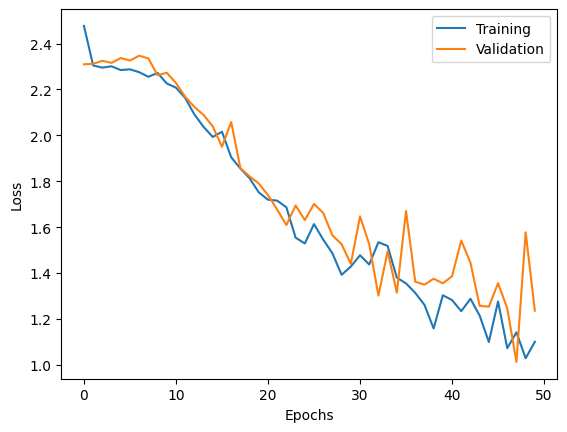

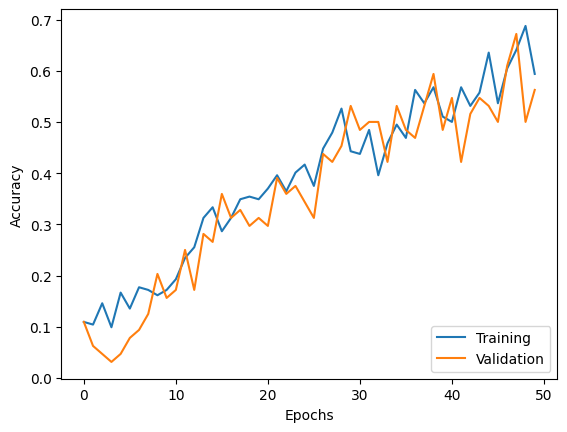

In [24]:
plot_history(hist)

## Predict method

    -load spectrogram
    -divide into slices
    -pad last slice if long enough
    -predict slices
    -average prediction or smth.

In [25]:
spec = load_random_spec_slice(df, 269)

model.predict(spec.reshape(1, *spec.shape, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


array([[1.9421907e-03, 2.6407168e-04, 2.1044305e-05, 9.3229551e-07,
        9.5700836e-01, 3.7265915e-02, 1.7996962e-08, 2.3013770e-06,
        1.0452916e-05, 3.4847541e-03]], dtype=float32)

In [26]:
def pad_spectrogram(spec, shape = cfg.input_dim, random = False):
    _ = np.zeros(shape)
    if random:
        rdm = random_int(maxval=shape[1]-spec.shape[1])
        _[:,rdm: rdm + spec.shape[1]] = spec 
    else:
        _[:,:spec.shape[1]] = spec
    return _

In [27]:
ID = 0
name = df.spectrogram.iloc[ID]
hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
spec_length = df.length_spectrogram.iloc[ID]
spec = load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None)
slices = []
for i in range(spec_length//cfg.input_dim[1]):
    slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration: # consider last slice, only if it is longer than the shortest clips in the dataset 
    slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
preds = model.predict(np.expand_dims(np.array(slices), axis = -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


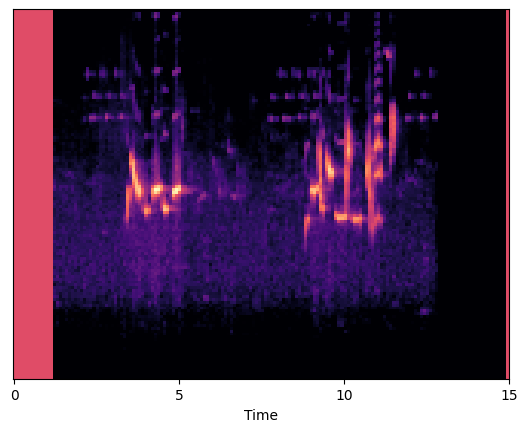

In [28]:
pad_spectrogram(slices[19]).shape

fig, ax = plt.subplots(1,1)
librosa.display.specshow(slices[19], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax);

In [29]:
def predict_file(df, ID, model):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    spec = load_spectrogram_slice(hdf5_path, name)
    slices = []
    
    for i in range(spec_length//cfg.input_dim[1]):
        slices.append(spec[:,i*cfg.input_dim[1]:(i+1)*cfg.input_dim[1]])
    if spec_length%cfg.input_dim[1]/cfg.input_dim[1] > 5/cfg.duration:
        # consider last slice, only if it is longer than the shortest clips in the dataset 
        slices.append(pad_spectrogram(spec[:, (i+1)*cfg.input_dim[1]:None], random = True))
    
    preds = model.predict(np.expand_dims(np.array(slices), axis = -1))
    
    return np.mean(preds, axis = 0) # return mean prediction

In [30]:
#preds = []
#for i in tqdm(df.index):
#    preds.append(predict_file(df, ID = i, model = model))

In [31]:
#preds = np.array(preds)
#classes = np.argmax(preds, axis = 1)

In [32]:
#classes_true = []
#for en in df.en:
#    classes_true.append(cfg.name2label[en])
#classes_true = np.array(classes_true)

In [33]:
#len(classes[classes == classes_true])/len(classes)

## Include time frequency mask layer
### (not working yet, idk why)

In [34]:
tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=2,
                                  freq_mask_param=15,
                                  time_mask_prob=0.5,
                                  num_time_masks=3,
                                  time_mask_param=15,
                                  time_last=True,
                        )

(128, 162)


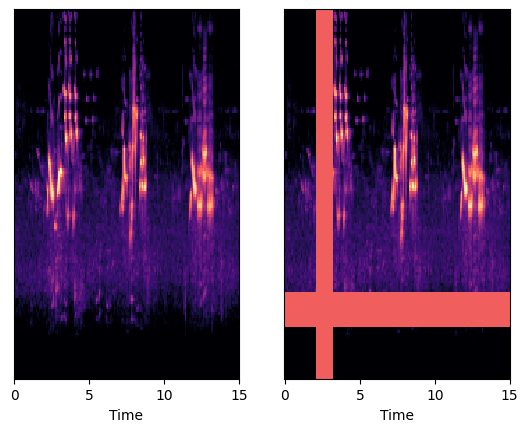

In [35]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,2)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[0]);
librosa.display.specshow(tfm_layer(spec.reshape(1, *cfg.input_dim, 1), training = True).numpy().reshape(*cfg.input_dim), 
                         sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[1]);

In [36]:
def build_model2():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    x = tfm_layer(x)
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Model2")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [37]:
model2 = build_model2()

Model: "Model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_freq_mask (TimeFreqMask)   │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 126, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 74880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     4,792,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,813,610 (18.36 MB)

 Trainable params: 4,813,610 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
hist2 = model2.fit(training_generator,
                    validation_data=validation_generator,
                    verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


W0000 00:00:1720823851.273178    4727 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. while/random_uniform/RandomUniform


6/6 - 10s - 2s/step - accuracy: 0.1042 - loss: 2.4077 - val_accuracy: 0.0938 - val_loss: 2.3573
Epoch 2/50
6/6 - 3s - 581ms/step - accuracy: 0.0781 - loss: 2.3028 - val_accuracy: 0.0625 - val_loss: 2.3104
Epoch 3/50
6/6 - 4s - 607ms/step - accuracy: 0.0729 - loss: 2.3005 - val_accuracy: 0.0625 - val_loss: 2.3052
Epoch 4/50
6/6 - 4s - 587ms/step - accuracy: 0.1094 - loss: 2.3012 - val_accuracy: 0.1094 - val_loss: 2.3062
Epoch 5/50
6/6 - 3s - 580ms/step - accuracy: 0.1250 - loss: 2.2952 - val_accuracy: 0.0312 - val_loss: 2.3114
Epoch 6/50
6/6 - 4s - 600ms/step - accuracy: 0.1146 - loss: 2.3079 - val_accuracy: 0.0469 - val_loss: 2.3123
Epoch 7/50
6/6 - 3s - 559ms/step - accuracy: 0.1406 - loss: 2.2928 - val_accuracy: 0.0625 - val_loss: 2.3019
Epoch 8/50
6/6 - 3s - 573ms/step - accuracy: 0.1094 - loss: 2.2830 - val_accuracy: 0.0469 - val_loss: 2.3095
Epoch 9/50
6/6 - 3s - 560ms/step - accuracy: 0.1302 - loss: 2.2715 - val_accuracy: 0.0938 - val_loss: 2.3120
Epoch 10/50
6/6 - 5s - 873ms/ste

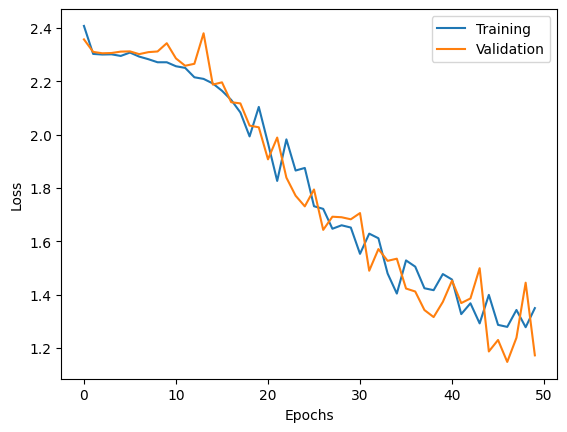

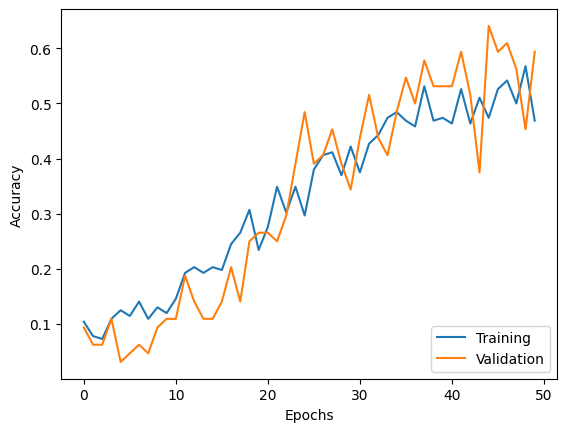

In [39]:
plot_history(hist2)

# Testing of some other architectures

In [40]:
input_dim = (128, 162, 1)

## DenseNet

In [41]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(include_top=False, input_shape=(128, 162, 1), weights=None)

def build_DenseNet():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    #x = tfm_layer(x)
    # Base model
    x = base_model(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "DenseNet")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [42]:
DenseNet = build_DenseNet()

Model: "DenseNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 5, 1024)     │     7,031,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       655,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,686,954 (29.32 MB)

 Trainable params: 7,603,306 (29.00 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [43]:
hist_dense = DenseNet.fit(training_generator,
                    validation_data=validation_generator,
                    verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


I0000 00:00:1720824158.158789    4727 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion_4', 20 bytes spill stores, 24 bytes spill loads



6/6 - 139s - 23s/step - accuracy: 0.1042 - loss: 3.1568 - val_accuracy: 0.0625 - val_loss: 2.3088
Epoch 2/50
6/6 - 4s - 679ms/step - accuracy: 0.1771 - loss: 2.1835 - val_accuracy: 0.0938 - val_loss: 2.3040
Epoch 3/50
6/6 - 4s - 635ms/step - accuracy: 0.1771 - loss: 2.1265 - val_accuracy: 0.0781 - val_loss: 2.3035
Epoch 4/50
6/6 - 4s - 629ms/step - accuracy: 0.2135 - loss: 2.0928 - val_accuracy: 0.0781 - val_loss: 2.3032
Epoch 5/50
6/6 - 4s - 680ms/step - accuracy: 0.1875 - loss: 2.1078 - val_accuracy: 0.0938 - val_loss: 2.3031
Epoch 6/50
6/6 - 4s - 652ms/step - accuracy: 0.2396 - loss: 1.9778 - val_accuracy: 0.1094 - val_loss: 2.3067
Epoch 7/50
6/6 - 5s - 837ms/step - accuracy: 0.2812 - loss: 1.8999 - val_accuracy: 0.0625 - val_loss: 2.3070
Epoch 8/50
6/6 - 4s - 631ms/step - accuracy: 0.3073 - loss: 1.9067 - val_accuracy: 0.0781 - val_loss: 2.3734
Epoch 9/50
6/6 - 4s - 637ms/step - accuracy: 0.3125 - loss: 1.8520 - val_accuracy: 0.1250 - val_loss: 2.3708
Epoch 10/50
6/6 - 4s - 693ms/s

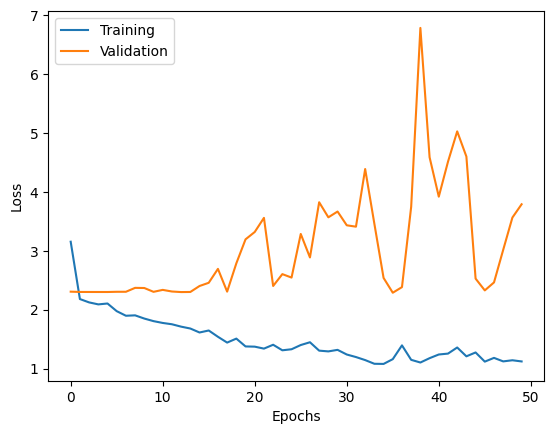

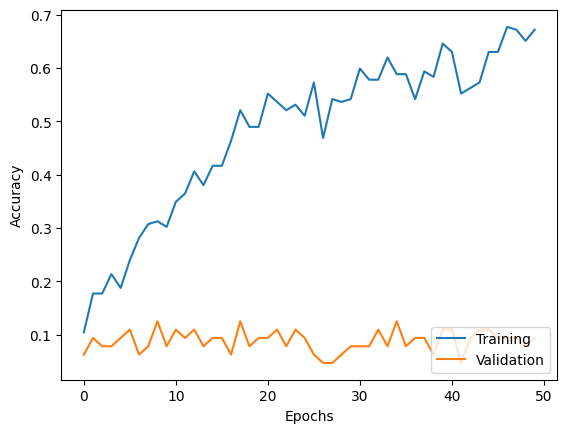

In [44]:
plot_history(hist_dense)

## EfficientNetB0

In [45]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, input_shape=(128, 162, 1), weights=None)

def build_EffNet():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    #x = tfm_layer(x)
    # Base model
    x = base_model(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "EffNet")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [46]:
EffNet = build_EffNet()

Model: "EffNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 6, 1280)     │     4,048,991 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       983,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,032,393 (19.20 MB)

 Trainable params: 4,990,374 (19.04 MB)

 Non-trainable params: 42,019 (164.14 KB)

In [47]:
hist_eff = EffNet.fit(training_generator,
                    validation_data=validation_generator,
                    verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50
6/6 - 83s - 14s/step - accuracy: 0.1042 - loss: 2.8801 - val_accuracy: 0.0469 - val_loss: 2.3082
Epoch 2/50
6/6 - 3s - 541ms/step - accuracy: 0.1823 - loss: 2.2411 - val_accuracy: 0.0625 - val_loss: 2.3159
Epoch 3/50
6/6 - 4s - 587ms/step - accuracy: 0.1615 - loss: 2.2142 - val_accuracy: 0.0469 - val_loss: 2.3386
Epoch 4/50
6/6 - 3s - 537ms/step - accuracy: 0.1875 - loss: 2.2040 - val_accuracy: 0.0781 - val_loss: 2.3242
Epoch 5/50
6/6 - 3s - 539ms/step - accuracy: 0.1927 - loss: 2.1845 - val_accuracy: 0.0625 - val_loss: 2.3474
Epoch 6/50
6/6 - 5s - 844ms/step - accuracy: 0.1979 - loss: 2.1174 - val_accuracy: 0.0625 - val_loss: 2.3553
Epoch 7/50
6/6 - 3s - 575ms/step - accuracy: 0.2083 - loss: 2.1693 - val_accuracy: 0.0469 - val_loss: 2.3424
Epoch 8/50
6/6 - 3s - 583ms/step - accuracy: 0.1719 - loss: 2.1341 - val_accuracy: 0.1406 - val_loss: 2.3338
Epoch 9/50
6/6 - 4s - 610ms/step - accuracy: 0.2083 - loss: 2.1339 - val_accuracy: 0.1562 - val_loss: 2.3356
Epoch 10/50
6/6 - 4s

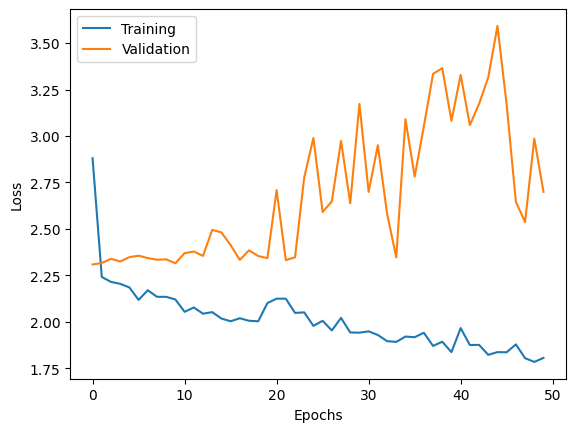

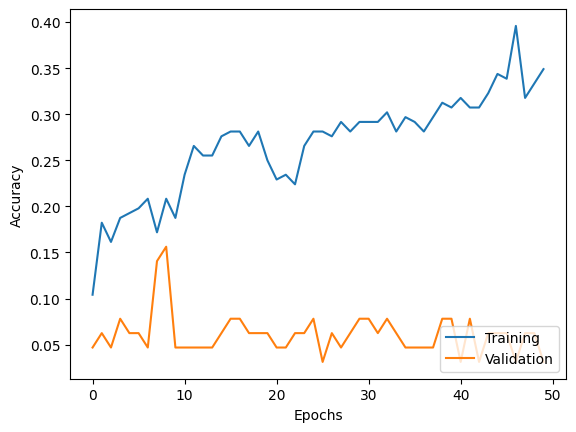

In [48]:
plot_history(hist_eff)

## Resnet

In [49]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top=False, input_shape=(128, 162, 1), weights=None)

def build_ResNet():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    #x = tfm_layer(x)
    # Base model
    x = base_model(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "ResNet")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [50]:
ResNet = build_ResNet()

Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_score_min_max (ZScoreMinMax)  │ (None, 128, 162, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 6, 2048)     │    23,581,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │     1,572,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,154,666 (95.96 MB)

 Trainable params: 25,101,546 (95.75 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [51]:
hist_res = EffNet.fit(training_generator,
                    validation_data=validation_generator,
                    verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50
6/6 - 4s - 707ms/step - accuracy: 0.3542 - loss: 1.7620 - val_accuracy: 0.0625 - val_loss: 2.9273
Epoch 2/50
6/6 - 4s - 600ms/step - accuracy: 0.3281 - loss: 1.7709 - val_accuracy: 0.0469 - val_loss: 3.5548
Epoch 3/50
6/6 - 3s - 564ms/step - accuracy: 0.3490 - loss: 1.8256 - val_accuracy: 0.0469 - val_loss: 3.3231
Epoch 4/50
6/6 - 4s - 600ms/step - accuracy: 0.3385 - loss: 1.7982 - val_accuracy: 0.0625 - val_loss: 2.6832
Epoch 5/50
6/6 - 4s - 606ms/step - accuracy: 0.3438 - loss: 1.7921 - val_accuracy: 0.1719 - val_loss: 2.5470
Epoch 6/50
6/6 - 4s - 587ms/step - accuracy: 0.3542 - loss: 1.7252 - val_accuracy: 0.0625 - val_loss: 3.4243
Epoch 7/50
6/6 - 4s - 640ms/step - accuracy: 0.3490 - loss: 1.7267 - val_accuracy: 0.0781 - val_loss: 3.0924
Epoch 8/50
6/6 - 4s - 595ms/step - accuracy: 0.3385 - loss: 1.8387 - val_accuracy: 0.0469 - val_loss: 3.1441
Epoch 9/50
6/6 - 4s - 592ms/step - accuracy: 0.3542 - loss: 1.8618 - val_accuracy: 0.0625 - val_loss: 2.3060
Epoch 10/50
6/6 - 4

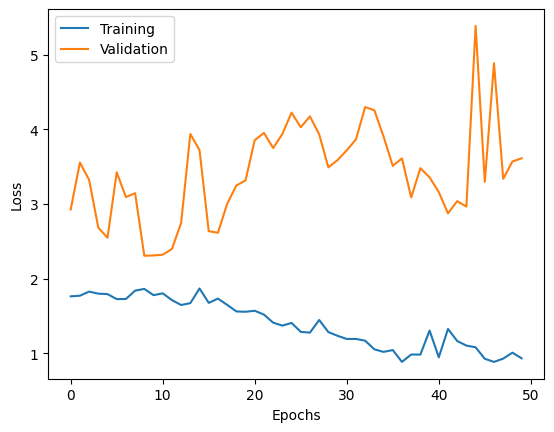

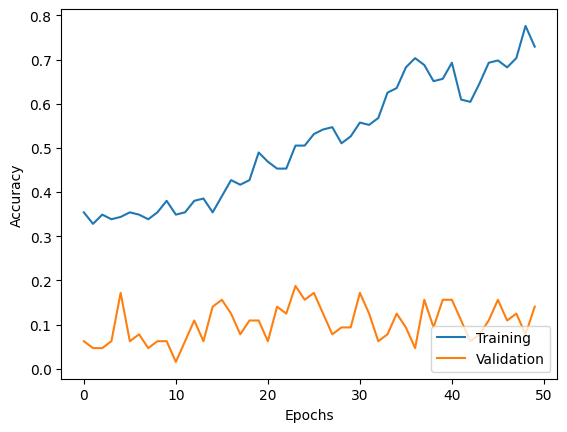

In [52]:
plot_history(hist_res)

In [53]:
def plot_histories(network_histories, labels, colors):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    for i in range(len(network_histories)):
        hist = network_histories[i]
        plt.plot(hist.history['loss'], label = labels[i] + ": loss", c = colors[i])
        plt.plot(hist.history['val_loss'], label = labels[i] + ": val_loss", ls = "dashed", c = colors[i])
    plt.legend()

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    for i in range(len(network_histories)):
        hist = network_histories[i]
        plt.plot(hist.history['accuracy'], label = labels[i] + ": accuracy", c = colors[i])
        plt.plot(hist.history['val_accuracy'], label = labels[i] + ": val_accuracy", ls = "dashed", c = colors[i])
    plt.legend()
    plt.show()

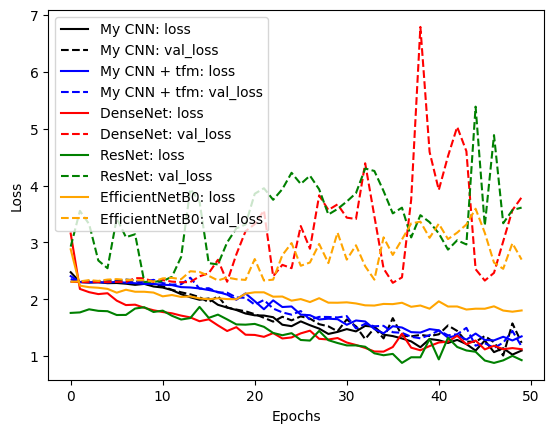

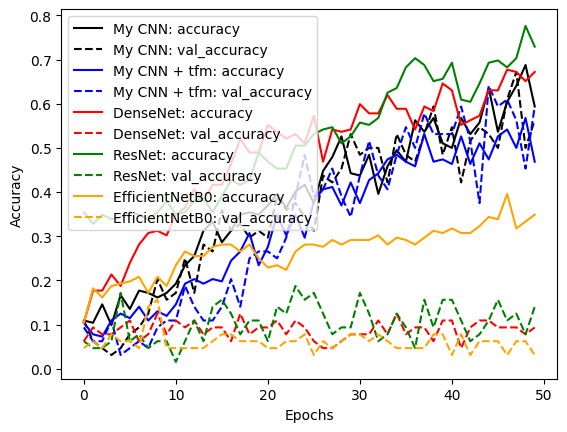

In [55]:
plot_histories([hist, hist2, hist_dense, hist_res, hist_eff], ["My CNN", "My CNN + tfm", "DenseNet", "ResNet", "EfficientNetB0"], 
               colors = ["black", "blue", "red", "green", "orange"])